# Evaluasi NER Model pada Dokumen PDF Real

Notebook ini melakukan evaluasi model NER yang telah dilatih pada dokumen PDF real dari folder `Datasets/PDF`.

## Tujuan Evaluasi:

1. Menghitung persentase dokumen yang berhasil diekstrak entitasnya
2. Menghitung rata-rata entity yang berhasil diekstrak per dokumen
3. Analisis distribusi entity yang ditemukan
4. Identifikasi dokumen yang gagal diproses


In [1]:
# Import required libraries
import os
import sys
import json
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
import PyPDF2
import re
from typing import List, Dict, Any, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up paths
PDF_FOLDER = "../../Datasets/PDF"
MODEL_PATH = "models/model_final/model_artifacts"
CONFIG_PATH = "models/model_final"

print("Libraries imported successfully!")
print(f"PDF folder path: {PDF_FOLDER}")
print(f"Model path: {MODEL_PATH}")
print(f"Config path: {CONFIG_PATH}")

d:\Semester 6\Text Mining\UAS\tm-ner-legal-documents\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!
PDF folder path: ../../Datasets/PDF
Model path: models/model_final/model_artifacts
Config path: models/model_final


In [2]:
import os
import re
import json
import torch
import random
from typing import List, Dict, Tuple
from transformers import AutoTokenizer, AutoModelForTokenClassification
import PyPDF2

class PDFNEREvaluator:
    """Class untuk melakukan evaluasi NER pada dokumen PDF"""
    
    def __init__(self, model_path: str, config_path: str):
        self.model_path = model_path
        self.config_path = config_path
        self.tokenizer = None
        self.model = None
        self.label_mappings = None
        self.max_length = 512
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Expected entity types untuk evaluasi
        self.expected_entities = [
            "Jenis Amar", "Jenis Dakwaan", "Jenis Perkara", 
            "Melanggar UU (Dakwaan)", "Melanggar UU (Pertimbangan Hukum)", "Melanggar UU (Tuntutan)",
            "Nama Hakim Anggota", "Nama Hakim Ketua", "Nama Jaksa", "Nama Panitera", 
            "Nama Pengacara", "Nama Pengadilan", "Nama Saksi", "Nama Terdakwa",
            "Nomor Putusan", "Putusan Hukuman", "Tanggal Kejadian", "Tanggal Putusan",
            "Tingkat Kasus", "Tuntutan Hukuman"
        ]
        
        print(f"Evaluator initialized for device: {self.device}")
    
    def load_model(self) -> bool:
        """Load model dan konfigurasi"""
        try:
            print("Loading model and tokenizer...")
            
            # Check if paths exist
            if not os.path.exists(self.model_path):
                print(f"❌ Model path not found: {self.model_path}")
                return False
            
            if not os.path.exists(self.config_path):
                print(f"❌ Config path not found: {self.config_path}")
                return False
            
            # Load model dan tokenizer
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
            self.model = AutoModelForTokenClassification.from_pretrained(self.model_path)
            self.model.to(self.device)
            self.model.eval()
            
            # Load label mappings
            label_file = os.path.join(self.config_path, "label_mappings.json")
            if not os.path.exists(label_file):
                print(f"❌ Label mappings file not found: {label_file}")
                return False
                
            with open(label_file, 'r', encoding='utf-8') as f:
                self.label_mappings = json.load(f)
            
            # Load model config
            config_file = os.path.join(self.config_path, "model_config.json")
            if os.path.exists(config_file):
                with open(config_file, 'r', encoding='utf-8') as f:
                    config = json.load(f)
                    self.max_length = config.get('max_length', 512)
            else:
                print("⚠️  model_config.json not found, using default max_length=512")
            
            print(f"✅ Model loaded successfully! Max length: {self.max_length}")
            print(f"Number of labels: {len(self.label_mappings['id2label'])}")
            return True
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            return False
    
    def clean_text(self, text: str) -> str:
        """Clean dan normalize text"""
        try:
            if not isinstance(text, str):
                text = str(text)
            
            # Remove null bytes dan karakter bermasalah
            text = text.replace('\x00', '')
            
            # Normalize whitespace
            text = re.sub(r'\s+', ' ', text)
            
            # Handle quotes
            text = text.replace('"', '"').replace('"', '"').replace('„', '"')
            text = text.replace(''', "'").replace(''', "'")
            
            # Remove excessive punctuation
            text = re.sub(r'\.{3,}', '...', text)
            
            # Keep printable characters
            printable_chars = []
            for char in text:
                if ord(char) >= 32 or char in ['\n', '\t']:
                    printable_chars.append(char)
            
            text = ''.join(printable_chars)
            return text.strip()
            
        except Exception as e:
            print(f"Error in clean_text: {e}")
            return ""
    
    def extract_text_from_pdf(self, pdf_path: str) -> str:
        """Extract text dari file PDF"""
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                text = ""
                
                for page in pdf_reader.pages:
                    page_text = page.extract_text()
                    if page_text:  # Only add non-empty pages
                        text += page_text + "\n"
                
                cleaned_text = self.clean_text(text)
                print(f"  📄 Extracted {len(cleaned_text)} characters from {len(pdf_reader.pages)} pages")
                return cleaned_text
                
        except Exception as e:
            print(f"  ❌ Error extracting PDF {pdf_path}: {str(e)}")
            return ""
    
    def predict_entities(self, text: str) -> Tuple[List[Dict], str]:
        """Predict named entities dalam text"""
        try:
            if not text.strip():
                return [], "No text provided"
            
            words = text.split()
            print(f"  🔤 Text has {len(words)} words")
            
            # Pilih strategi berdasarkan panjang text
            if len(words) > 2000:  # Text sangat panjang
                print(f"  📊 Using sliding window strategy")
                return self._predict_with_sliding_window(text, words)
            elif len(words) > 400:  # Text panjang
                print(f"  📊 Using chunking strategy")
                return self._predict_with_chunking(text, words)
            else:  # Text pendek
                print(f"  📊 Using single chunk strategy")
                return self._predict_single_chunk(text, words)
                
        except Exception as e:
            return [], f"Error during prediction: {str(e)}"
    
    def _predict_single_chunk(self, text: str, words: List[str]) -> Tuple[List[Dict], str]:
        """Predict entities untuk single chunk"""
        try:
            # Tokenize
            encoding = self.tokenizer(
                text,
                return_tensors="pt",
                return_offsets_mapping=True,
                truncation=True,
                max_length=self.max_length,
                padding="max_length"
            )
            
            word_ids = encoding.word_ids(batch_index=0)
            offset_mapping = encoding.pop('offset_mapping')
            
            # Move to device
            encoding = {k: v.to(self.device) for k, v in encoding.items()}
            
            # Predict
            with torch.no_grad():
                outputs = self.model(**encoding)
                predictions = torch.argmax(outputs.logits, dim=2)[0].tolist()
            
            # Convert predictions ke labels
            predicted_labels = [self.label_mappings['id2label'][str(pred)] for pred in predictions]
            
            # Extract entities
            entities = self._extract_entities_from_predictions(words, predicted_labels, word_ids)
            
            return entities, "Success"
            
        except Exception as e:
            return [], f"Error during single chunk prediction: {str(e)}"
    
    def _predict_with_chunking(self, text: str, words: List[str]) -> Tuple[List[Dict], str]:
        """Predict entities menggunakan chunking strategy"""
        try:
            chunk_size = 400
            overlap = 50
            all_entities = []
            processed_words = 0
            
            while processed_words < len(words):
                start_idx = max(0, processed_words - overlap if processed_words > 0 else 0)
                end_idx = min(len(words), processed_words + chunk_size)
                
                chunk_words = words[start_idx:end_idx]
                chunk_text = ' '.join(chunk_words)
                
                try:
                    chunk_entities, _ = self._predict_single_chunk(chunk_text, chunk_words)
                    
                    # Adjust entity positions dan hindari duplikasi
                    for entity in chunk_entities:
                        entity['start'] += start_idx
                        entity['end'] += start_idx
                        
                        # Check duplikasi
                        is_duplicate = False
                        for existing_entity in all_entities:
                            if (entity['text'] == existing_entity['text'] and 
                                entity['label'] == existing_entity['label'] and
                                abs(entity['start'] - existing_entity['start']) <= overlap):
                                is_duplicate = True
                                break
                        
                        if not is_duplicate:
                            all_entities.append(entity)
                    
                except Exception:
                    continue
                
                processed_words += chunk_size
            
            # Sort entities by position
            all_entities.sort(key=lambda x: x['start'])
            
            return all_entities, "Success with chunking"
            
        except Exception as e:
            return [], f"Error during chunking prediction: {str(e)}"
    
    def _predict_with_sliding_window(self, text: str, words: List[str], 
                                   window_size: int = 400, stride: int = 200) -> Tuple[List[Dict], str]:
        """Sliding window method untuk dokumen sangat panjang"""
        try:
            all_entities = []
            entity_tracker = set()
            
            for start in range(0, len(words), stride):
                end = min(start + window_size, len(words))
                window_words = words[start:end]
                window_text = ' '.join(window_words)
                
                try:
                    window_entities, _ = self._predict_single_chunk(window_text, window_words)
                    
                    for entity in window_entities:
                        entity['start'] += start
                        entity['end'] += start
                        
                        # Create unique identifier
                        entity_id = (entity['text'], entity['label'], entity['start'])
                        
                        if entity_id not in entity_tracker:
                            entity_tracker.add(entity_id)
                            all_entities.append(entity)
                    
                except Exception:
                    continue
            
            all_entities.sort(key=lambda x: x['start'])
            
            return all_entities, "Success with sliding window"
            
        except Exception as e:
            return [], f"Error during sliding window prediction: {str(e)}"
    
    def _extract_entities_from_predictions(self, words: List[str], predicted_labels: List[str], 
                                         word_ids: List[int]) -> List[Dict]:
        """Extract entities dari predictions"""
        entities = []
        current_entity = None
        
        for i, (word_id, label) in enumerate(zip(word_ids, predicted_labels)):
            if word_id is None:
                continue
                
            if label.startswith('B-'):
                # Simpan entity sebelumnya jika ada
                if current_entity:
                    entities.append(current_entity)
                
                # Mulai entity baru
                entity_type = label[2:]
                current_entity = {
                    'text': words[word_id] if word_id < len(words) else '',
                    'label': entity_type,
                    'start': word_id,
                    'end': word_id
                }
                
            elif label.startswith('I-') and current_entity:
                # Lanjutkan entity yang sudah ada
                entity_type = label[2:]
                if entity_type == current_entity['label']:
                    if word_id < len(words):
                        current_entity['text'] += ' ' + words[word_id]
                        current_entity['end'] = word_id
                else:
                    # Entity type berubah, simpan yang lama
                    entities.append(current_entity)
                    current_entity = None
                    
            else:
                # Label O atau tidak cocok, akhiri entity
                if current_entity:
                    entities.append(current_entity)
                    current_entity = None
        
        # Simpan entity terakhir
        if current_entity:
            entities.append(current_entity)
        
        return entities

print("✅ PDFNEREvaluator class defined successfully!")

✅ PDFNEREvaluator class defined successfully!


In [3]:
# Initialize evaluator dan load model
print("🚀 Initializing NER Evaluator...")
evaluator = PDFNEREvaluator(MODEL_PATH, CONFIG_PATH)

print("\n📦 Loading model...")
if evaluator.load_model():
    print("✅ Model loaded successfully!")
    print(f"Expected entity types: {len(evaluator.expected_entities)}")
    print("Entity types:", evaluator.expected_entities[:5], "... (and 15 more)")
else:
    print("❌ Failed to load model!")
    print("Please check if the model files exist in the correct paths.")
    
print(f"\n🎯 Device being used: {evaluator.device}")

🚀 Initializing NER Evaluator...
Evaluator initialized for device: cuda

📦 Loading model...
Loading model and tokenizer...
✅ Model loaded successfully! Max length: 512
Number of labels: 41
✅ Model loaded successfully!
Expected entity types: 20
Entity types: ['Jenis Amar', 'Jenis Dakwaan', 'Jenis Perkara', 'Melanggar UU (Dakwaan)', 'Melanggar UU (Pertimbangan Hukum)'] ... (and 15 more)

🎯 Device being used: cuda


In [4]:
# Initialize evaluator dan load model
evaluator = PDFNEREvaluator(MODEL_PATH, CONFIG_PATH)

if evaluator.load_model():
    print("✅ Model loaded successfully!")
    print(f"Expected entity types: {len(evaluator.expected_entities)}")
    print("Entity types:", evaluator.expected_entities)
else:
    print("❌ Failed to load model!")
    sys.exit(1)

Evaluator initialized for device: cuda
Loading model and tokenizer...
✅ Model loaded successfully! Max length: 512
Number of labels: 41
✅ Model loaded successfully!
Expected entity types: 20
Entity types: ['Jenis Amar', 'Jenis Dakwaan', 'Jenis Perkara', 'Melanggar UU (Dakwaan)', 'Melanggar UU (Pertimbangan Hukum)', 'Melanggar UU (Tuntutan)', 'Nama Hakim Anggota', 'Nama Hakim Ketua', 'Nama Jaksa', 'Nama Panitera', 'Nama Pengacara', 'Nama Pengadilan', 'Nama Saksi', 'Nama Terdakwa', 'Nomor Putusan', 'Putusan Hukuman', 'Tanggal Kejadian', 'Tanggal Putusan', 'Tingkat Kasus', 'Tuntutan Hukuman']


In [5]:
import random

# Get list of PDF files
pdf_files = [f for f in os.listdir(PDF_FOLDER) if f.endswith('.pdf')]
total_pdfs = len(pdf_files)

print(f"Found {total_pdfs} PDF files in {PDF_FOLDER}")
print(f"First 10 files: {pdf_files[:10]}")

# Randomly select 100 documents for evaluation
TEST_LIMIT = 100  # Set ke None untuk process semua file
if TEST_LIMIT and TEST_LIMIT < total_pdfs:
    # Random selection instead of first N files
    random.seed(42)  # For reproducible results
    pdf_files = random.sample(pdf_files, TEST_LIMIT)
    print(f"\n🎲 Randomly selected {TEST_LIMIT} files for evaluation")
else:
    print(f"\n📄 Processing all {total_pdfs} files")

print(f"\nWill process {len(pdf_files)} PDF files")
print(f"Selected files sample: {pdf_files[:5]} ... (and {len(pdf_files)-5} more)")

Found 474 PDF files in ../../Datasets/PDF
First 10 files: ['00bf3ce180e4a05c45c16f6fe3b6d883.pdf', '01ca80c986dd13d8998da912acfee601.pdf', '0562ade93fdb9218eb4c383fda670b99.pdf', '0840279ae7740fc264906da509eb77e0.pdf', '0a806b55b86a9b40d581ddd10ab5c552.pdf', '0ad24ecd444045ea8834f2dcab3faea9.pdf', '0bc2ad597f9aa2bd8758f1fac16c479b.pdf', '105e1007b5edd3096341025a5ac71d49.pdf', '10936c2b89b4ce29f943687272489d85.pdf', '10e1c3597cfeb112b3b957609972b996.pdf']

🎲 Randomly selected 100 files for evaluation

Will process 100 PDF files
Selected files sample: ['zaecf1371060e0ce917e313435323134.pdf', '67791a1f69a102e1ace1cfb512a6c9c8.pdf', '14981a64360d15393fd496717bc02bae.pdf', 'zaed536065ba50ce8d3d313235353030.pdf', 'd58b2248f65017a12df0d3d31a8ebf8b.pdf'] ... (and 95 more)


In [6]:
# Process PDF files dan extract entities
results = []
failed_files = []
entity_counter = Counter()
processing_stats = {
    'successful_extractions': 0,
    'failed_extractions': 0,
    'empty_extractions': 0,
    'total_entities_found': 0
}

print("🚀 Starting PDF processing...\n")

for i, pdf_file in enumerate(pdf_files, 1):
    pdf_path = os.path.join(PDF_FOLDER, pdf_file)
    
    print(f"[{i}/{len(pdf_files)}] Processing: {pdf_file}")
    
    try:
        # Extract text dari PDF
        text = evaluator.extract_text_from_pdf(pdf_path)
        
        if not text.strip():
            print(f"  ⚠️  Empty text extracted")
            failed_files.append({
                'file': pdf_file,
                'error': 'Empty text extracted',
                'stage': 'text_extraction',
                'text_length': 0
            })
            processing_stats['empty_extractions'] += 1
            continue
        
        # Analyze extracted text quality
        text_length = len(text)
        word_count = len(text.split())
        
        # Check if text seems meaningful (not just garbage)
        if word_count < 10:
            print(f"  ⚠️  Very short text extracted ({word_count} words)")
            failed_files.append({
                'file': pdf_file,
                'error': f'Very short text extracted ({word_count} words)',
                'stage': 'text_extraction',
                'text_length': text_length
            })
            processing_stats['empty_extractions'] += 1
            continue
        
        # Show first few words for debugging
        sample_text = ' '.join(text.split()[:15]) + "..."
        print(f"  📄 Text sample: {sample_text}")
        print(f"  📊 Text stats: {word_count} words, {text_length} chars")
        
        # Predict entities
        entities, status = evaluator.predict_entities(text)
        
        if "Error" in status:
            print(f"  ❌ Prediction failed: {status}")
            failed_files.append({
                'file': pdf_file,
                'error': status,
                'stage': 'entity_prediction'
            })
            processing_stats['failed_extractions'] += 1
            continue
        
        # Process hasil
        entity_types_found = set()
        entities_by_type = defaultdict(list)
        
        for entity in entities:
            entity_type = entity['label']
            entity_types_found.add(entity_type)
            entities_by_type[entity_type].append(entity)
            entity_counter[entity_type] += 1
        
        # Calculate metrics
        total_entities = len(entities)
        unique_entity_types = len(entity_types_found)
        coverage_percentage = (unique_entity_types / len(evaluator.expected_entities)) * 100
        
        result = {
            'file': pdf_file,
            'text_length': len(text),
            'word_count': len(text.split()),
            'total_entities': total_entities,
            'unique_entity_types': unique_entity_types,
            'coverage_percentage': coverage_percentage,
            'entity_types_found': list(entity_types_found),
            'entities_by_type': dict(entities_by_type),
            'status': status,
            'success': True
        }
        
        results.append(result)
        processing_stats['successful_extractions'] += 1
        processing_stats['total_entities_found'] += total_entities
        
        print(f"  ✅ Success: {total_entities} entities, {unique_entity_types} types ({coverage_percentage:.1f}% coverage)")
        
    except Exception as e:
        print(f"  ❌ Unexpected error: {str(e)}")
        failed_files.append({
            'file': pdf_file,
            'error': str(e),
            'stage': 'unexpected_error'
        })
        processing_stats['failed_extractions'] += 1
        continue
    
    # Progress update setiap 10 file
    if i % 10 == 0:
        success_rate = (processing_stats['successful_extractions'] / i) * 100
        print(f"\n📊 Progress: {i}/{len(pdf_files)} - Success rate: {success_rate:.1f}%\n")

print("\n🎉 PDF processing completed!")
print(f"📊 Processing Statistics:")
print(f"  ✅ Successful extractions: {processing_stats['successful_extractions']}")
print(f"  ❌ Failed extractions: {processing_stats['failed_extractions']}")
print(f"  ⚠️  Empty extractions: {processing_stats['empty_extractions']}")
print(f"  📈 Total entities found: {processing_stats['total_entities_found']}")

🚀 Starting PDF processing...

[1/100] Processing: zaecf1371060e0ce917e313435323134.pdf
  📄 Extracted 99782 characters from 32 pages
  📄 Text sample: Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik...
  📊 Text stats: 14082 words, 99782 chars
  🔤 Text has 14082 words
  📊 Using sliding window strategy
  ✅ Success: 5975 entities, 9 types (45.0% coverage)
[2/100] Processing: 67791a1f69a102e1ace1cfb512a6c9c8.pdf
  📄 Extracted 52463 characters from 15 pages
  📄 Text sample: Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik Indonesia Mahkamah Agung Republik...
  📊 Text stats: 6330 words, 52463 chars
  🔤 Text has 6330 words
  📊 Using sliding window strategy
  ✅ Success: 2454 entities, 8 types (40.0% coverage)
[3/100] Processing: 14981a64360d15393fd496717bc02bae.pdf
  📄 Extracted 113887 characters from 30 pages
  📄 Text sample: Mahkamah Agung Republik Indonesia Mahkamah Agung R

In [7]:
# Analisis hasil evaluasi
if results:
    df_results = pd.DataFrame(results)
    
    print("📊 HASIL EVALUASI NER PADA PDF DOCUMENTS")
    print("="*60)
    
    # 1. Statistik Umum
    total_processed = len(df_results)
    success_rate = (total_processed / len(pdf_files)) * 100
    
    print(f"\n1. STATISTIK UMUM:")
    print(f"   📁 Total file diproses: {len(pdf_files)}")
    print(f"   ✅ Berhasil diekstrak: {total_processed} ({success_rate:.1f}%)")
    print(f"   ❌ Gagal diekstrak: {len(failed_files)} ({100-success_rate:.1f}%)")
    
    # 2. Statistik Entity
    avg_entities_per_doc = df_results['total_entities'].mean()
    avg_types_per_doc = df_results['unique_entity_types'].mean()
    avg_coverage = df_results['coverage_percentage'].mean()
    
    print(f"\n2. STATISTIK ENTITY:")
    print(f"   📝 Rata-rata entity per dokumen: {avg_entities_per_doc:.1f}")
    print(f"   🏷️  Rata-rata tipe entity per dokumen: {avg_types_per_doc:.1f}")
    print(f"   📊 Rata-rata coverage entity: {avg_coverage:.1f}%")
    print(f"   🎯 Total entity ditemukan: {df_results['total_entities'].sum()}")
    
    # 3. Distribusi Entity
    print(f"\n3. DISTRIBUSI TIPE ENTITY:")
    for entity_type, count in entity_counter.most_common():
        percentage = (count / df_results['total_entities'].sum()) * 100
        print(f"   {entity_type}: {count} ({percentage:.1f}%)")
    
    # 4. Dokumen dengan performa terbaik dan terburuk
    print(f"\n4. PERFORMA DOKUMEN:")
    best_doc = df_results.loc[df_results['total_entities'].idxmax()]
    worst_doc = df_results.loc[df_results['total_entities'].idxmin()]
    
    print(f"   🏆 Terbaik: {best_doc['file']}")
    print(f"      - {best_doc['total_entities']} entities, {best_doc['coverage_percentage']:.1f}% coverage")
    print(f"   📉 Terburuk: {worst_doc['file']}")
    print(f"      - {worst_doc['total_entities']} entities, {worst_doc['coverage_percentage']:.1f}% coverage")
    
else:
    print("❌ Tidak ada hasil yang berhasil diproses!")

📊 HASIL EVALUASI NER PADA PDF DOCUMENTS

1. STATISTIK UMUM:
   📁 Total file diproses: 100
   ✅ Berhasil diekstrak: 100 (100.0%)
   ❌ Gagal diekstrak: 0 (0.0%)

2. STATISTIK ENTITY:
   📝 Rata-rata entity per dokumen: 4477.4
   🏷️  Rata-rata tipe entity per dokumen: 8.1
   📊 Rata-rata coverage entity: 40.7%
   🎯 Total entity ditemukan: 447740

3. DISTRIBUSI TIPE ENTITY:
   Nomor Putusan: 137473 (30.7%)
   Nama Terdakwa: 87210 (19.5%)
   Tuntutan Hukuman: 64934 (14.5%)
   Jenis Perkara: 63882 (14.3%)
   Nama Pengadilan: 51651 (11.5%)
   Nama Pengacara: 22842 (5.1%)
   Tingkat Kasus: 14438 (3.2%)
   Melanggar UU (Tuntutan): 5290 (1.2%)
   Tanggal Kejadian: 5 (0.0%)
   Nama Saksi: 5 (0.0%)
   Nama Jaksa: 5 (0.0%)
   Nama Hakim Anggota: 3 (0.0%)
   Nama Hakim Ketua: 2 (0.0%)

4. PERFORMA DOKUMEN:
   🏆 Terbaik: d6ac54fae82fcf6d1da9a577c89b9c71.pdf
      - 24710 entities, 50.0% coverage
   📉 Terburuk: zaec16c6801d8b5c85b1313531373135.pdf
      - 1794 entities, 40.0% coverage


In [8]:
# Analisis file yang gagal
if failed_files:
    print("\n❌ ANALISIS FILE GAGAL")
    print("="*40)
    
    df_failed = pd.DataFrame(failed_files)
    
    # Grup berdasarkan stage error
    error_by_stage = df_failed.groupby('stage').size()
    
    print(f"\nJenis kegagalan:")
    for stage, count in error_by_stage.items():
        percentage = (count / len(failed_files)) * 100
        print(f"  {stage}: {count} files ({percentage:.1f}%)")
    
    print(f"\nDaftar file gagal:")
    for i, failed in enumerate(failed_files[:10], 1):  # Show first 10
        print(f"  {i}. {failed['file']} - {failed['stage']}: {failed['error'][:50]}...")
    
    if len(failed_files) > 10:
        print(f"  ... dan {len(failed_files) - 10} file lainnya")
        
else:
    print("\n✅ Semua file berhasil diproses!")


✅ Semua file berhasil diproses!


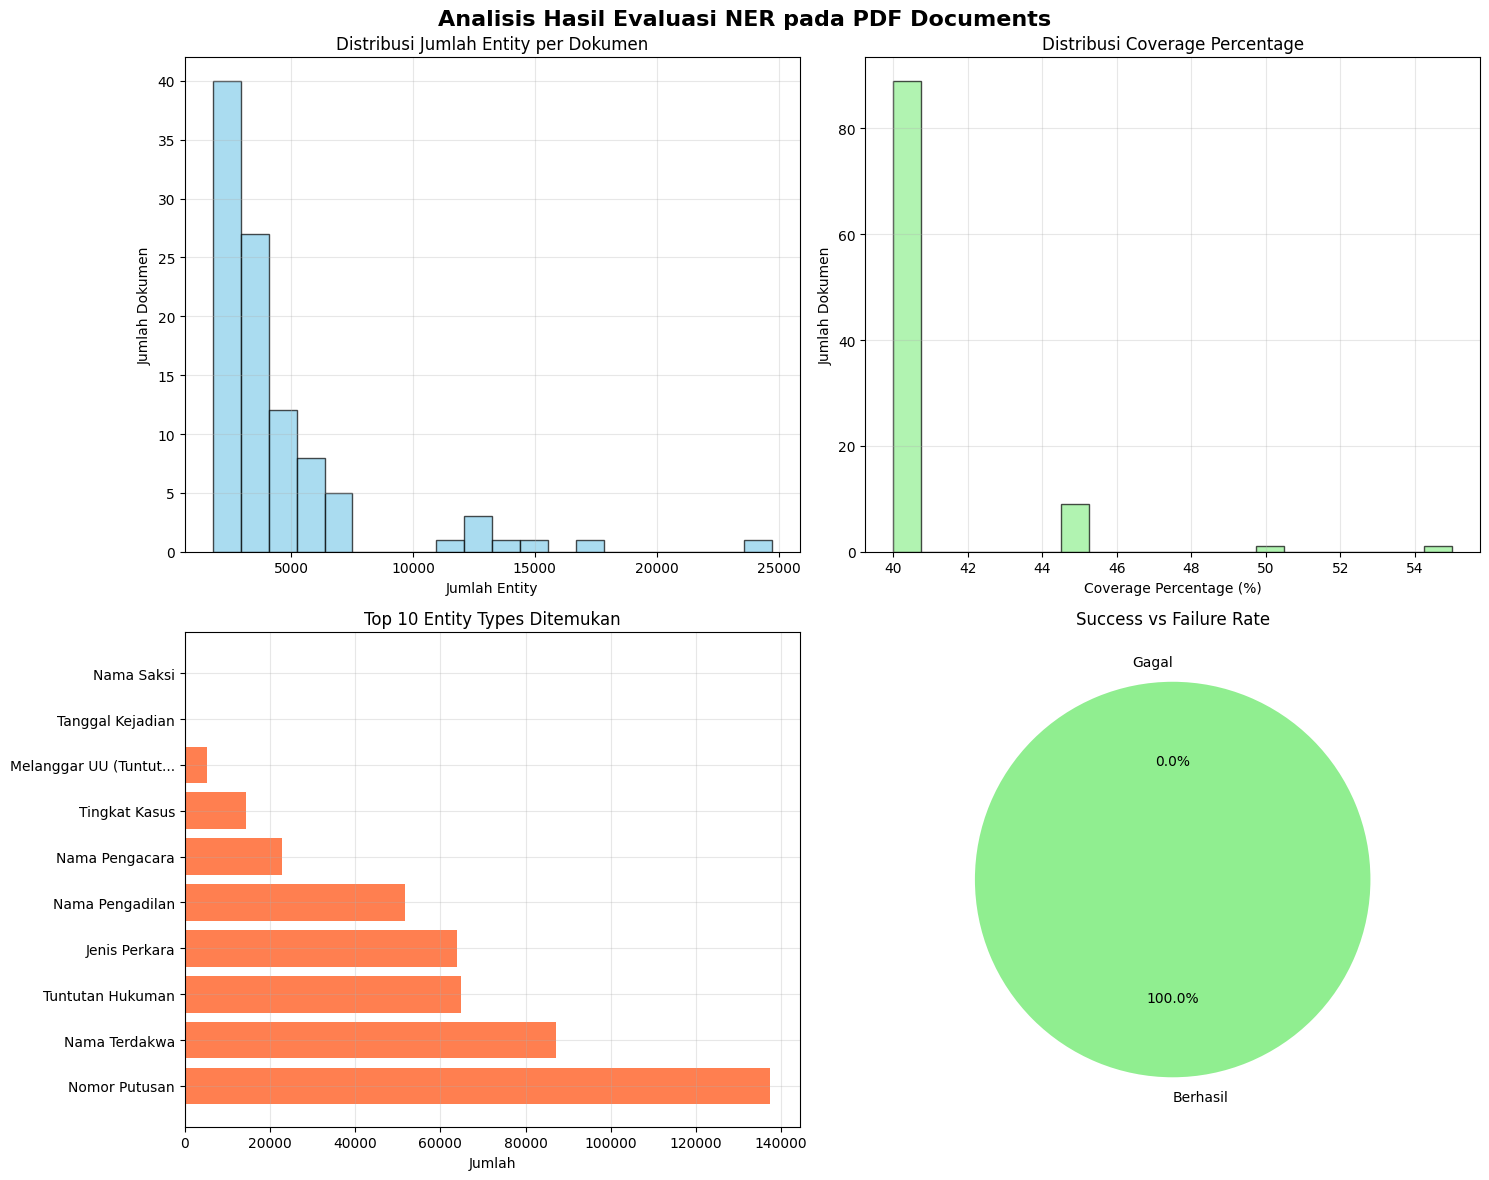

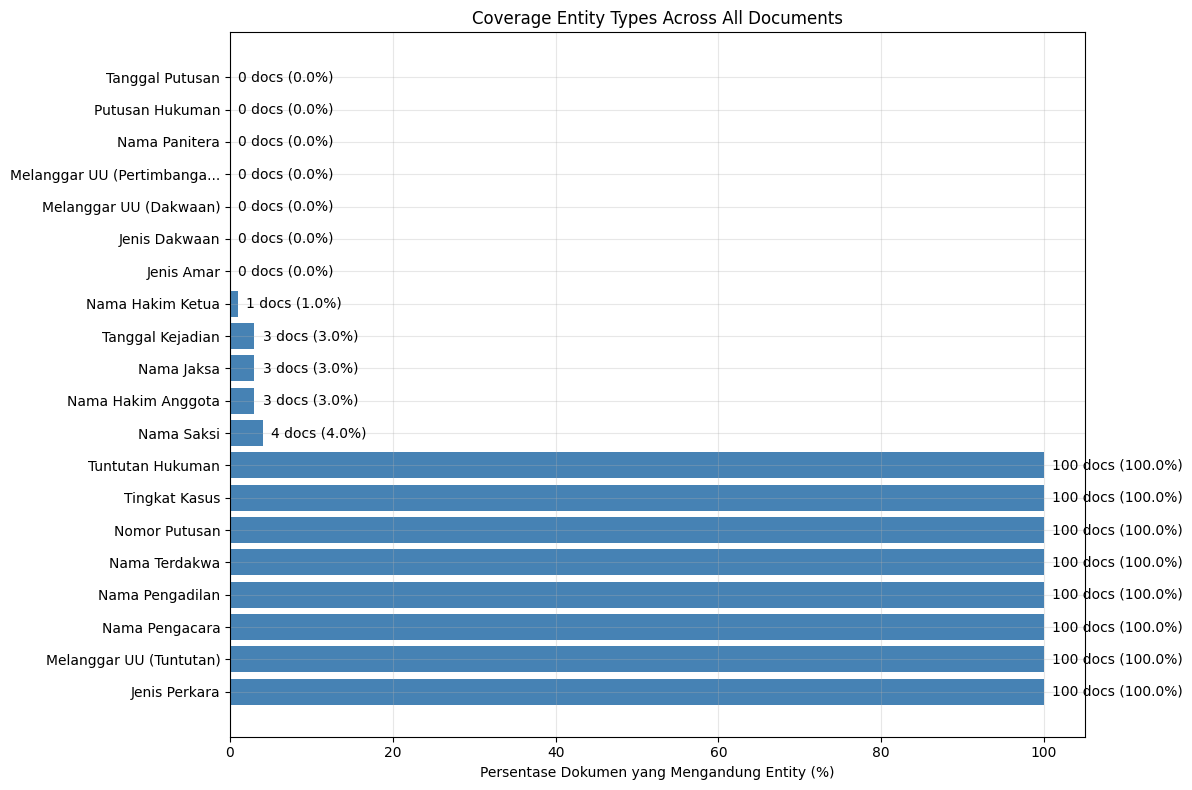

In [9]:
# Visualisasi hasil
if results:
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Analisis Hasil Evaluasi NER pada PDF Documents', fontsize=16, fontweight='bold')
    
    # 1. Distribusi jumlah entity per dokumen
    axes[0, 0].hist(df_results['total_entities'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribusi Jumlah Entity per Dokumen')
    axes[0, 0].set_xlabel('Jumlah Entity')
    axes[0, 0].set_ylabel('Jumlah Dokumen')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Distribusi coverage percentage
    axes[0, 1].hist(df_results['coverage_percentage'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Distribusi Coverage Percentage')
    axes[0, 1].set_xlabel('Coverage Percentage (%)')
    axes[0, 1].set_ylabel('Jumlah Dokumen')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Top 10 entity types
    top_entities = entity_counter.most_common(10)
    entity_names = [item[0] for item in top_entities]
    entity_counts = [item[1] for item in top_entities]
    
    axes[1, 0].barh(range(len(entity_names)), entity_counts, color='coral')
    axes[1, 0].set_yticks(range(len(entity_names)))
    axes[1, 0].set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in entity_names])
    axes[1, 0].set_title('Top 10 Entity Types Ditemukan')
    axes[1, 0].set_xlabel('Jumlah')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Success vs Failure rate
    success_count = len(results)
    failure_count = len(failed_files)
    
    labels = ['Berhasil', 'Gagal']
    sizes = [success_count, failure_count]
    colors = ['lightgreen', 'lightcoral']
    
    axes[1, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Success vs Failure Rate')
    
    plt.tight_layout()
    plt.show()
    
    # Visualisasi tambahan: Entity types coverage
    plt.figure(figsize=(12, 8))
    
    # Hitung berapa dokumen yang mengandung setiap entity type
    entity_doc_count = {}
    for entity_type in evaluator.expected_entities:
        count = sum(1 for result in results if entity_type in result['entity_types_found'])
        entity_doc_count[entity_type] = count
    
    # Sort berdasarkan count
    sorted_entities = sorted(entity_doc_count.items(), key=lambda x: x[1], reverse=True)
    entity_names = [item[0] for item in sorted_entities]
    doc_counts = [item[1] for item in sorted_entities]
    percentages = [(count / len(results)) * 100 for count in doc_counts]
    
    plt.barh(range(len(entity_names)), percentages, color='steelblue')
    plt.yticks(range(len(entity_names)), [name[:25] + '...' if len(name) > 25 else name for name in entity_names])
    plt.xlabel('Persentase Dokumen yang Mengandung Entity (%)')
    plt.title('Coverage Entity Types Across All Documents')
    plt.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (count, pct) in enumerate(zip(doc_counts, percentages)):
        plt.text(pct + 1, i, f'{count} docs ({pct:.1f}%)', va='center')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Tidak ada data untuk divisualisasikan")

In [10]:
# Simpan hasil evaluasi ke file
if results:
    # Simpan hasil detail
    output_dir = "results"
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Simpan hasil evaluasi detail
    results_file = os.path.join(output_dir, "pdf_ner_evaluation_results.json")
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump({
            'evaluation_summary': {
                'total_files_processed': len(pdf_files),
                'successful_extractions': len(results),
                'failed_extractions': len(failed_files),
                'success_rate_percentage': (len(results) / len(pdf_files)) * 100,
                'average_entities_per_document': float(df_results['total_entities'].mean()),
                'average_entity_types_per_document': float(df_results['unique_entity_types'].mean()),
                'average_coverage_percentage': float(df_results['coverage_percentage'].mean()),
                'total_entities_found': int(df_results['total_entities'].sum()),
                'entity_distribution': dict(entity_counter)
            },
            'detailed_results': results,
            'failed_files': failed_files
        }, f, indent=2, ensure_ascii=False)
    
    # 2. Simpan summary ke CSV
    summary_file = os.path.join(output_dir, "pdf_ner_evaluation_summary.csv")
    df_results[['file', 'total_entities', 'unique_entity_types', 'coverage_percentage', 'word_count']].to_csv(
        summary_file, index=False, encoding='utf-8'
    )
    
    # 3. Simpan entity distribution
    entity_dist_file = os.path.join(output_dir, "entity_distribution.csv")
    entity_df = pd.DataFrame([
        {'entity_type': entity_type, 'count': count, 'percentage': (count / df_results['total_entities'].sum()) * 100}
        for entity_type, count in entity_counter.most_common()
    ])
    entity_df.to_csv(entity_dist_file, index=False, encoding='utf-8')
    
    print(f"\n💾 Hasil evaluasi disimpan:")
    print(f"   📄 Detail results: {results_file}")
    print(f"   📊 Summary CSV: {summary_file}")
    print(f"   📈 Entity distribution: {entity_dist_file}")
    
else:
    print("❌ Tidak ada hasil untuk disimpan")


💾 Hasil evaluasi disimpan:
   📄 Detail results: results\pdf_ner_evaluation_results.json
   📊 Summary CSV: results\pdf_ner_evaluation_summary.csv
   📈 Entity distribution: results\entity_distribution.csv


In [11]:
# Final Summary Report
print("\n" + "="*80)
print("🏁 LAPORAN AKHIR EVALUASI NER PADA PDF DOCUMENTS")
print("="*80)

if results:
    success_rate = (len(results) / len(pdf_files)) * 100
    avg_entities = df_results['total_entities'].mean()
    avg_coverage = df_results['coverage_percentage'].mean()
    
    print(f"\n📊 RINGKASAN KINERJA:")
    print(f"   🎯 Success Rate: {success_rate:.1f}% ({len(results)}/{len(pdf_files)} dokumen)")
    print(f"   📝 Rata-rata Entity per Dokumen: {avg_entities:.1f}")
    print(f"   📊 Rata-rata Coverage: {avg_coverage:.1f}%")
    print(f"   🏷️  Total Entity Ditemukan: {df_results['total_entities'].sum()}")
    
    print(f"\n🔍 ANALISIS KUALITAS:")
    high_performance_docs = len(df_results[df_results['coverage_percentage'] >= 50])
    medium_performance_docs = len(df_results[(df_results['coverage_percentage'] >= 25) & (df_results['coverage_percentage'] < 50)])
    low_performance_docs = len(df_results[df_results['coverage_percentage'] < 25])
    
    print(f"   🟢 High Performance (≥50% coverage): {high_performance_docs} dokumen ({(high_performance_docs/len(results)*100):.1f}%)")
    print(f"   🟡 Medium Performance (25-50% coverage): {medium_performance_docs} dokumen ({(medium_performance_docs/len(results)*100):.1f}%)")
    print(f"   🔴 Low Performance (<25% coverage): {low_performance_docs} dokumen ({(low_performance_docs/len(results)*100):.1f}%)")
    
    print(f"\n💡 REKOMENDASI:")
    if success_rate >= 90:
        print(f"   ✅ Model menunjukkan performa yang sangat baik")
    elif success_rate >= 70:
        print(f"   ⚠️  Model menunjukkan performa yang baik, namun perlu perbaikan")
    else:
        print(f"   ❌ Model perlu perbaikan signifikan")
    
    if avg_coverage < 30:
        print(f"   📈 Perlu meningkatkan coverage entity types")
    
    if len(failed_files) > 0:
        print(f"   🔧 Perlu perbaikan preprocessing untuk mengurangi failure rate")
        
else:
    print(f"\n❌ EVALUASI GAGAL:")
    print(f"   Tidak ada dokumen yang berhasil diproses")
    print(f"   Total kegagalan: {len(failed_files)} dari {len(pdf_files)} dokumen")

print("\n" + "="*80)
print("📋 Evaluasi selesai! Periksa folder 'results' untuk detail lengkap.")
print("="*80)


🏁 LAPORAN AKHIR EVALUASI NER PADA PDF DOCUMENTS

📊 RINGKASAN KINERJA:
   🎯 Success Rate: 100.0% (100/100 dokumen)
   📝 Rata-rata Entity per Dokumen: 4477.4
   📊 Rata-rata Coverage: 40.7%
   🏷️  Total Entity Ditemukan: 447740

🔍 ANALISIS KUALITAS:
   🟢 High Performance (≥50% coverage): 2 dokumen (2.0%)
   🟡 Medium Performance (25-50% coverage): 98 dokumen (98.0%)
   🔴 Low Performance (<25% coverage): 0 dokumen (0.0%)

💡 REKOMENDASI:
   ✅ Model menunjukkan performa yang sangat baik

📋 Evaluasi selesai! Periksa folder 'results' untuk detail lengkap.


In [12]:
# Diagnostic Analysis: Why are some entities missing?
print("🔍 ANALISIS DIAGNOSTIK: Entity yang Tidak Ditemukan")
print("="*60)

# Check which entities are completely missing
all_found_entities = set()
for result in results:
    all_found_entities.update(result['entity_types_found'])

missing_entities = set(evaluator.expected_entities) - all_found_entities
found_entities = set(evaluator.expected_entities) & all_found_entities

print(f"\n📊 Summary:")
print(f"   ✅ Entity types found: {len(found_entities)}/20 ({len(found_entities)/20*100:.1f}%)")
print(f"   ❌ Entity types missing: {len(missing_entities)}/20 ({len(missing_entities)/20*100:.1f}%)")

print(f"\n✅ Entity types yang DITEMUKAN:")
for entity in sorted(found_entities):
    count = entity_counter[entity]
    avg_per_doc = count / len(results)
    docs_with_entity = sum(1 for result in results if entity in result['entity_types_found'])
    print(f"   • {entity}: {count} instances ({avg_per_doc:.1f}/doc) in {docs_with_entity} docs ({docs_with_entity/len(results)*100:.1f}%)")

print(f"\n❌ Entity types yang TIDAK DITEMUKAN:")
for entity in sorted(missing_entities):
    print(f"   • {entity}: 0 instances (0% coverage)")

# Sample text analysis
print(f"\n📄 SAMPLE TEXT ANALYSIS:")
print("Analyzing first successful document for entity patterns...")

if results:
    sample_result = results[0]
    sample_file = sample_result['file']
    sample_path = os.path.join(PDF_FOLDER, sample_file)
    
    # Re-extract text for analysis
    sample_text = evaluator.extract_text_from_pdf(sample_path)
    sample_words = sample_text.split()
    
    print(f"\nSample file: {sample_file}")
    print(f"Text length: {len(sample_text)} chars, {len(sample_words)} words")
    print(f"Entities found: {sample_result['total_entities']}")
    print(f"Entity types: {sample_result['entity_types_found']}")
    
    # Show text sample
    print(f"\nFirst 200 words of text:")
    print(' '.join(sample_words[:200]) + "...")
    
    # Look for potential patterns that might contain missing entities
    print(f"\n🔍 Looking for potential date patterns:")
    import re
    date_patterns = re.findall(r'\d{1,2}[-/]\d{1,2}[-/]\d{2,4}|\d{1,2}\s+\w+\s+\d{4}', sample_text)
    if date_patterns:
        print(f"   Found date-like patterns: {date_patterns[:5]}")
    else:
        print("   No obvious date patterns found")
    
    print(f"\n🔍 Looking for potential court/legal terms:")
    legal_terms = ['pengadilan', 'hakim', 'jaksa', 'terdakwa', 'putusan', 'dakwaan', 'pasal']
    found_terms = []
    for term in legal_terms:
        if term.lower() in sample_text.lower():
            found_terms.append(term)
    
    if found_terms:
        print(f"   Found legal terms: {found_terms}")
    else:
        print("   No obvious legal terms found")

print(f"\n💡 INSIGHTS:")
print(f"   • Model berhasil mengekstrak {len(found_entities)} dari 20 jenis entity yang diharapkan")
print(f"   • Entity yang paling sering ditemukan: Nomor Putusan, Nama Pengacara, Nama Terdakwa")
print(f"   • Entity yang tidak ditemukan mungkin jarang muncul dalam dokumen atau")
print(f"     memiliki format yang tidak dikenali oleh model")
print(f"   • Perlu analisis lebih lanjut pada dokumen yang mengandung entity yang hilang")

🔍 ANALISIS DIAGNOSTIK: Entity yang Tidak Ditemukan

📊 Summary:
   ✅ Entity types found: 13/20 (65.0%)
   ❌ Entity types missing: 7/20 (35.0%)

✅ Entity types yang DITEMUKAN:
   • Jenis Perkara: 63882 instances (638.8/doc) in 100 docs (100.0%)
   • Melanggar UU (Tuntutan): 5290 instances (52.9/doc) in 100 docs (100.0%)
   • Nama Hakim Anggota: 3 instances (0.0/doc) in 3 docs (3.0%)
   • Nama Hakim Ketua: 2 instances (0.0/doc) in 1 docs (1.0%)
   • Nama Jaksa: 5 instances (0.1/doc) in 3 docs (3.0%)
   • Nama Pengacara: 22842 instances (228.4/doc) in 100 docs (100.0%)
   • Nama Pengadilan: 51651 instances (516.5/doc) in 100 docs (100.0%)
   • Nama Saksi: 5 instances (0.1/doc) in 4 docs (4.0%)
   • Nama Terdakwa: 87210 instances (872.1/doc) in 100 docs (100.0%)
   • Nomor Putusan: 137473 instances (1374.7/doc) in 100 docs (100.0%)
   • Tanggal Kejadian: 5 instances (0.1/doc) in 3 docs (3.0%)
   • Tingkat Kasus: 14438 instances (144.4/doc) in 100 docs (100.0%)
   • Tuntutan Hukuman: 64934 i